In [22]:
import torch
import dclllib
import pylab as plt
device = 'cuda'

### Loading MNIST data as spiketrains

The following function will load the MNIST dataset using torchvision modules. It'll download an pre-pre-process the data for faster usage.

In [2]:
gen_train = dclllib.get_mnist_loader(100, train=True)
gen_test = dclllib.get_mnist_loader(100, train=False)

Pre-processing dataset: 100%|██████████| 10000/10000 [00:00<00:00, 10987.54it/s]


Because MNIST is an image, we need to transform it into a spiketrain. The function image2spiketrain takes case of this.

In [3]:
datait = iter(gen_train)
raw_input, raw_labels = next(datait)
data, labels1h = dclllib.image2spiketrain(raw_input, raw_labels, max_duration=1000, gain=100)
data_t = torch.FloatTensor(data)
labels_t = torch.Tensor(labels1h)

Let's examine the shape of data:

In [4]:
data.shape

(1000, 100, 1, 28, 28)

1000 here corresponds to the number of time setps, 100 is the batchsize, 1 is the number of channels and 28,28 are the height and width, respectively. The last three dimensions will important when we'll use convolutional or locally connected layers, but for the moment, our network has no structure,, so we will flatten them.

Here is what one sample looks like

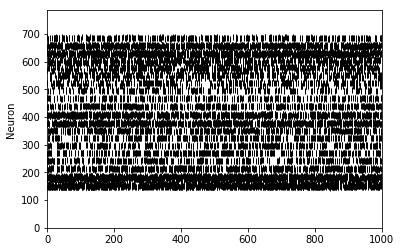

(<matplotlib.axes._subplots.AxesSubplot at 0x7f6de0404ba8>, None)

In [5]:
dclllib.plotLIF(U=None,S=data_t[:,0].view(1000,-1).data.numpy())

The average reate here is more revealing. Our MNIST input spike trains are simply flattened spiketrains representing the digit image in the firing rates.

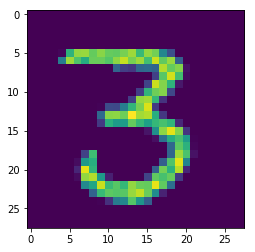

In [6]:
plt.imshow(data_t[:,0].data.numpy().mean(axis=0).reshape(28,28))

Let's create an iterator function that does all these steps:

In [23]:
def iter_mnist(gen_train, batchsize=100, T=1000, max_rate = 100):
    datait = iter(gen_train)
    for raw_input, raw_labels in datait:
        data, labels1h = dclllib.image2spiketrain(raw_input, raw_labels, max_duration=T, gain=max_rate)
        data_t = torch.FloatTensor(data).view(T,batchsize,-1)
        labels_t = torch.Tensor(labels1h)
        yield data_t, labels_t  

### Creating the MNIST Nwtwork

We make use of dcll.py, which contains a cleanly written DCLL module.

In [24]:
import dcll

The following creates a three layer DCLL network

In [47]:
data, target = next(iter_mnist(gen_train, T=T))
net = dcll.DCLL(Nin = 784, Nout=10, Nhid = 128).cuda()

Set up loss and optimization

In [48]:
mse_loss = torch.nn.MSELoss()
opt = torch.optim.Adam(net.get_trainable_parameters(), lr=1e-4, betas=[0., .95])

def dcll_loss(r, s, tgt):
    loss_tv = 0
    for i in range(len(r)):
        loss_tv += mse_loss(r[i],tgt) + .1*torch.mean(s[i][-1])
    return loss_tv

Initialize the DCLL network with the correct batch size

In [ ]:
net.init(data[0].to(device))

Train the network

In [46]:
for e in range(T):    
    loss_hist = 0
    for data, label in iter_mnist(gen_train, T=T):
        data_d = data.to(device)
        label_d = label.to(device)
        for n in range(T):
            st, rt = net.forward(data_d[n])        
            loss_tv = dcll_loss(rt, st, label_d[n])
            loss_tv.backward()
            opt.step()
            opt.zero_grad()
        loss_hist += loss_tv
    print(e, loss_hist)

KeyboardInterrupt: 

### Loading MNIST data as spiketrains